<a href="https://colab.research.google.com/github/Liza-b-13/liza-repo/blob/main/notebook/detection_PE_Headers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Détection de malwares par machine automatique utilisant les PE Headers**

(Pour les premiers tests j'utiliserais un jeu de données différent que celui prévu...)


### **Jeu de données**
- Fichiers légitimes : 41 323 binaires Windows  
- Fichiers malveillants : 96 724 téléchargés depuis VirusShare  
- Total : 138 048 fichiers  
- Créé par : Prateek Lalwani  
- Lien du dataset :  [link](https://github.com/PacktPublishing/Mastering-Machine-Learning-for-Penetration-Testing/blob/master/Chapter03/MalwareData.csv.gz)

### **Qu’est-ce que les PE headers ?**
Les **PE headers** (Portable Executable headers) sont des structures au début d’un fichier exécutable Windows (.exe, .dll, .sys…).  
Ils contiennent des informations essentielles comme :  
- Type et architecture du fichier (32-bit ou 64-bit)  
- Sections du fichier (code, données, ressources…)  
- Adresses et tailles des sections en mémoire  
- Bibliothèques et fonctions importées/exportées  

En analyse de malware, les PE headers permettent de **différencier un fichier légitime d’un fichier malveillant** grâce à certaines de leurs caractéristiques.



---


### **Prétraitement du jeu de données:**

In [3]:
import pandas as pd
url = "https://raw.githubusercontent.com/PacktPublishing/Mastering-Machine-Learning-for-Penetration-Testing/master/Chapter03/MalwareData.csv.gz"

# Reads directly from the gzip file
MalwareDataset = pd.read_csv(url, compression='gzip', sep='|', low_memory=False)

# Check shape and preview
print(MalwareDataset.shape)
MalwareDataset.head()

(138047, 57)


,Name,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
0,memtest.exe,631ea355665f28d4707448e442fbf5b8,332,224,258,9,0,361984,115712,0,...,4,3.262823,2.568844,3.537939,8797.000000,216,18032,0,16,1
1,ose.exe,9d10f99a6712e28f8acd5641e3a7ea6b,332,224,3330,9,0,130560,19968,0,...,2,4.250461,3.420744,5.080177,837.000000,518,1156,72,18,1
2,setup.exe,4d92f518527353c0db88a70fddcfd390,332,224,3330,9,0,517120,621568,0,...,11,4.426324,2.846449,5.271813,31102.272727,104,270376,72,18,1
3,DW20.EXE,a41e524f8d45f0074fd07805ff0c9b12,332,224,258,9,0,585728,369152,0,...,10,4.364291,2.669314,6.400720,1457.000000,90,4264,72,18,1
4,dwtrig20.exe,c87e561258f2f8650cef999bf643a731,332,224,258,9,0,294912,247296,0,...,2,4.306100,3.421598,5.190603,1074.500000,849,1300,72,18,1


 Explication du code

- **`pandas`** : bibliothèque Python utilisée pour manipuler et analyser des données tabulaires.  
- **`pd.read_csv()`** : lit un fichier CSV (ou un fichier compressé `.gz`) et le charge dans un DataFrame.  
  - `compression='gzip'` → permet de lire le fichier compressé sans le décompresser manuellement.  
  - `sep='|'` → indique que les colonnes sont séparées par le caractère `|` au lieu d’une virgule.


---



In [4]:
Legit = MalwareDataset[0:41323].drop(['legitimate'], axis=1) #drops the column legitimate cause we have it as variable now
Malware = MalwareDataset[41323::].drop(['legitimate'], axis=1)

print("The shape of the legit dataset is: %s samples, %s features"%(Legit.shape[0], Legit.shape[1]))
print("The shape of the malware dataset is: %s samples, %s features"%(Malware.shape[0],Malware.shape[1]))

The shape of the legit dataset is: 41323 samples, 56 features
The shape of the malware dataset is: 96724 samples, 56 features


**Code Explanation:**

`Legit.shape` gives the dimensions of the DataFrame as a tuple:
→ `(number_of_rows, number_of_columns)`

`Legit.shape[0]` → number of rows (samples)

`Legit.shape[1]` → number of columns (features)



---



In [5]:
print(MalwareDataset.columns) #printing all the features from the dataset

Index(['Name', 'md5', 'Machine', 'SizeOfOptionalHeader', 'Characteristics',
       'MajorLinkerVersion', 'MinorLinkerVersion', 'SizeOfCode',
       'SizeOfInitializedData', 'SizeOfUninitializedData',
       'AddressOfEntryPoint', 'BaseOfCode', 'BaseOfData', 'ImageBase',
       'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion',
       'MinorOperatingSystemVersion', 'MajorImageVersion', 'MinorImageVersion',
       'MajorSubsystemVersion', 'MinorSubsystemVersion', 'SizeOfImage',
       'SizeOfHeaders', 'CheckSum', 'Subsystem', 'DllCharacteristics',
       'SizeOfStackReserve', 'SizeOfStackCommit', 'SizeOfHeapReserve',
       'SizeOfHeapCommit', 'LoaderFlags', 'NumberOfRvaAndSizes', 'SectionsNb',
       'SectionsMeanEntropy', 'SectionsMinEntropy', 'SectionsMaxEntropy',
       'SectionsMeanRawsize', 'SectionsMinRawsize', 'SectionMaxRawsize',
       'SectionsMeanVirtualsize', 'SectionsMinVirtualsize',
       'SectionMaxVirtualsize', 'ImportsNbDLL', 'ImportsNb',
       'Impor

In [6]:
pd.set_option('display.max_columns', None) #to show all the columns, otherwise it cuts out most cause too long
print(MalwareDataset.head(5)) #printing the first 5 lines

           Name                               md5  Machine  \
0   memtest.exe  631ea355665f28d4707448e442fbf5b8      332   
1       ose.exe  9d10f99a6712e28f8acd5641e3a7ea6b      332   
2     setup.exe  4d92f518527353c0db88a70fddcfd390      332   
3      DW20.EXE  a41e524f8d45f0074fd07805ff0c9b12      332   
4  dwtrig20.exe  c87e561258f2f8650cef999bf643a731      332   

   SizeOfOptionalHeader  Characteristics  MajorLinkerVersion  \
0                   224              258                   9   
1                   224             3330                   9   
2                   224             3330                   9   
3                   224              258                   9   
4                   224              258                   9   

   MinorLinkerVersion  SizeOfCode  SizeOfInitializedData  \
0                   0      361984                 115712   
1                   0      130560                  19968   
2                   0      517120                 621568   
3 



---


### 🌿 **Decision Tree Classifier**

A Decision Tree Classifier is a model that makes decisions by asking a series of yes/no questions about the data — like a flowchart.

In [7]:
import sklearn
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score

In [8]:
data_in = MalwareDataset.drop(['Name','md5','legitimate'], axis=1).values # .values converts the DataFrame to a NumPy array because the model wants a mathematical array not the pandas one
labels = MalwareDataset['legitimate'].values #we use that column as a label
extratrees = ExtraTreesClassifier().fit(data_in, labels)
select = SelectFromModel(extratrees, prefit=True)
data_in_new = select.transform(data_in)
print("shape of the old dataset %s , shape of the new dataset %s"  %(data_in.shape, data_in_new.shape))

shape of the old dataset (138047, 54) , shape of the new dataset (138047, 15)


**Explanation:**

Here we train an Extra Trees model to determine feature importance, and then use that information to create a new dataset (data_in_new) containing only the most relevant features for our malware detection task.

In [9]:
import numpy as np
features = data_in_new.shape[1] #number of features
importances = extratrees.feature_importances_
indices = np.argsort(importances)[::-1] #argsort returns the indices that would sort an array in ascending order

for f in range(features):
    print("%d"%(f+1), MalwareDataset.columns[2+indices[f]], importances[indices[f]])


1 DllCharacteristics 0.15589913441983863
2 Machine 0.11151683257614872
3 Characteristics 0.10406152153410757
4 VersionInformationSize 0.07558453825828333
5 Subsystem 0.06407766482973519
6 MajorSubsystemVersion 0.05209594744162259
7 SectionsMaxEntropy 0.04611504935595923
8 ImageBase 0.043582249054805455
9 ResourcesMinEntropy 0.038854139723696696
10 ResourcesMaxEntropy 0.03662100753988896
11 SizeOfOptionalHeader 0.031618802650477354
12 SectionsMeanEntropy 0.024966814986432342
13 SizeOfStackReserve 0.02088386194527271
14 MajorOperatingSystemVersion 0.018997438354448767
15 SectionsMinEntropy 0.01893094660017465




---


### 🌳Training our model with a **random forest classifier**

A Random Forest Classifier is an ensemble of many decision trees combined together.
* It trains many decision trees (often hundreds).

* Each tree sees a random subset of the data and features.

* When predicting, each tree votes for a class.

* The majority vote becomes the final prediction.

It's better than a simple tree classifier because it's:

* More accurate: reduces overfitting (a single tree can memorize data).

* More stable: less sensitive to noise in the data.

* More robust: averages out errors from individual trees.

In [10]:
Legit_Train, Legit_Test, Malware_Train, Malware_Test = train_test_split(data_in_new, labels, test_size=0.2)
classif = sklearn.ensemble.RandomForestClassifier(n_estimators=50) #nombre d'arbres
classif.fit(Legit_Train, Malware_Train)
score = classif.score(Legit_Test, Malware_Test)
print("The accuracy of the algorithm is: %s" %(score*100))

The accuracy of the algorithm is: 99.41325606664252


 **Interprétation des résultats**

Le score semble très prometteur :  
le modèle a détecté les malwares avec **un taux de réussite de 99 %**, ce qui est un excellent résultat.  

Cela signifie que le **classifieur Random Forest** (avec 50 arbres dans la forêt) a correctement distingué la majorité des fichiers légitimes et malveillants.   

> ⚠️ Attention : un score aussi élevé peut aussi indiquer un **possible surapprentissage (overfitting)**, il faudra donc valider le modèle avec d’autres jeux de données ou des méthodes de validation croisée.


In [11]:
from sklearn.metrics import confusion_matrix
result = classif.predict(Legit_Test)
conf_mat = confusion_matrix(Malware_Test, result)
print("Taux de faux positifs: %f %%" % ((conf_mat[0][1] / float(sum(conf_mat[0])))*100))
print('Taux de faux negatifs: %f %%' % ( (conf_mat[1][0] / float(sum(conf_mat[1]))*100)))

Taux de faux positifs: 0.504473 %
Taux de faux negatifs: 0.775471 %


Vérifier s'il ya surapprentissage par validation croisée:

In [12]:
from sklearn.model_selection import cross_validate
scores = cross_validate(classif, Legit_Train, Malware_Train, cv=5)
print(scores)

{'fit_time': array([5.60345793, 6.46253252, 5.39638066, 6.41894698, 5.74109197]), 'score_time': array([0.09848332, 0.09268904, 0.09520411, 0.0996964 , 0.09508514]), 'test_score': array([0.99456719, 0.99298261, 0.99397836, 0.9935256 , 0.99384253])}


Pour visualiser ça:

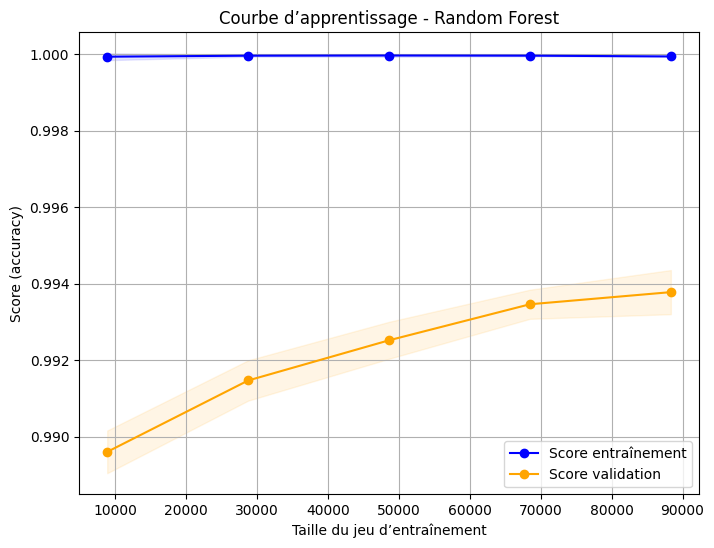

In [13]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    classif,               # ton modèle Random Forest déjà défini et entraîné
    Legit_Train,           # tes features d'entraînement
    Malware_Train,         # tes labels d'entraînement
    cv=5,                  # validation croisée à 5 plis
    n_jobs=-1,             # utilise tous les cœurs CPU
    train_sizes=np.linspace(0.1, 1.0, 5),  # 10%, 25%, 50%, 75%, 100% des données
    shuffle=True,
    random_state=42
)

# Moyennes et écarts-types
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Tracé de la courbe
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Score entraînement')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes, test_mean, 'o-', color='orange', label='Score validation')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='orange')

plt.title("Courbe d’apprentissage - Random Forest")
plt.xlabel("Taille du jeu d’entraînement")
plt.ylabel("Score (accuracy)")
plt.legend(loc="best")
plt.grid(True)
plt.show()




---



## **Gradient Boosting**

Le Gradient Boosting est une méthode d'apprentissage supervisé très puissante, utilisée pour la classification et la régression.  

### Comment ça fonctionne :
1. Il construit une **série d'arbres de décision faibles (weak learners)**, chacun corrigeant les erreurs du précédent.  
2. Chaque nouvel arbre est entraîné pour **minimiser les erreurs résiduelles** des arbres précédents.  
3. Les prédictions finales sont obtenues en **combinant tous les arbres**, généralement par une somme pondérée.

### Pourquoi l’utiliser pour la détection de malwares :
- Très efficace pour capturer des **patterns complexes dans les données**.  
- Peut améliorer la précision par rapport à un **Random Forest** simple.  
- Permet de **réduire les faux positifs et faux négatifs** si bien paramétré.


In [14]:
classif_gradient = sklearn.ensemble.GradientBoostingClassifier(n_estimators=50)
classif_gradient.fit(Legit_Train, Malware_Train)
score_gradient = classif_gradient.score(Legit_Test, Malware_Test)
print("The accuracy of the algorithm is: %s" %(score_gradient*100))

The accuracy of the algorithm is: 98.86635277073525




---



### **AdaBoost Classifier**

**AdaBoost** (Adaptive Boosting) est une méthode d'**apprentissage supervisé** utilisée pour la classification (et parfois la régression).  

### Principe de fonctionnement :
1. AdaBoost construit une **série de classifieurs faibles** (souvent des petits arbres de décision).  
2. Chaque nouvel arbre se concentre **sur les erreurs des classifieurs précédents** :  
   - Les exemples mal classés reçoivent un **poids plus élevé** pour être mieux appris par le classifieur suivant.  
3. Les prédictions finales sont obtenues en **combinant tous les classifieurs** avec un système de **votes pondérés**.

### Pourquoi l’utiliser pour la détection de malwares :
- Il est capable de **corriger progressivement les erreurs** sur les fichiers difficiles à classer.  
- Peut améliorer la **précision globale** et réduire les **faux positifs et faux négatifs**.  
- Plus simple et souvent plus rapide à entraîner que le Gradient Boosting, tout en restant performant.


In [15]:
classif_adboost = sklearn.ensemble.AdaBoostClassifier(n_estimators=100)
classif_adboost.fit(Legit_Train, Malware_Train)
score_adboost = classif_adboost.score(Legit_Test, Malware_Test)
print("The accuracy of the algorithm is: %s" %(score_adboost*100))

The accuracy of the algorithm is: 98.61282144150671


### **XGBoost**

In [16]:
import xgboost as xgb

classif_xgb = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, use_label_encoder=False, eval_metric='logloss')
classif_xgb.fit(Legit_Train, Malware_Train)
score_xgb = classif_xgb.score(Legit_Test, Malware_Test)
print("The accuracy of the XGBoost algorithm is: %s" %(score_xgb*100))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:29:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


The accuracy of the XGBoost algorithm is: 99.28649040202825


## **Hyperparamétrage**
L’étape d’hyperparamétrage consiste à rechercher la meilleure combinaison de paramètres pour optimiser les performances des modèles d’apprentissage supervisé.

Nous utilisons ici la méthode de validation croisée combinée à une recherche exhaustive (`GridSearchCV`) afin de sélectionner les paramètres les plus adaptés pour deux modèles : Random Forest et XGBoos, car ce sont les plus performants.


In [17]:
from sklearn.model_selection import GridSearchCV

### Définition des grilles de paramètres
Nous définissons des plages de valeurs raisonnables pour les hyperparamètres clés de chaque modèle :


In [18]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30]  # Maximum depth of the tree
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200],  # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2], # Step size shrinkage used in update to prevent overfitting
    'max_depth': [3, 5, 7]  # Maximum depth of a tree
}

### Hyperparamétrage pour random forest

Nous utilisons `GridSearchCV` avec une validation croisée à 5 plis (cv=5) pour identifier la meilleure configuration de paramètres pour le modèle Random Forest :


**Reasoning**:
Import the RandomForestClassifier, instantiate it, and then instantiate GridSearchCV with the model, parameter grid, and cross-validation setting. Finally, fit GridSearchCV to the training data.



In [19]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()

grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5)

grid_search_rf.fit(Legit_Train, Malware_Train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'n_estimators': [50, 100, 200]})

In [20]:
print("Meilleurs paramètres pour Random Forest:", grid_search_rf.best_params_)
print("Meilleure score (cross-validation):", grid_search_rf.best_score_)

Best parameters for Random Forest: {'max_depth': 20, 'n_estimators': 100}
Best cross-validation score for Random Forest: 0.9938969669464408


### Hyperparamétrage pour XGBoost:

De la même manière, nous procédons à un réglage d’hyperparamètres pour le modèle XGBoost :

In [21]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5)

grid_search_xgb.fit(Legit_Train, Malware_Train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:03:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:03:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:03:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:03:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:03:44] WARNING: /w

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]})

In [23]:
print("Meilleurs paramètres pour XGBoost :", grid_search_xgb.best_params_)
print("Meilleure score (cross-validation) :", grid_search_xgb.best_score_)

Meilleurs paramètres pour XGBoost : {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Meilleure score (cross-validation) : 0.9935891009159443


### Résumé

L’hyperparamétrage permet ainsi d’optimiser les performances des deux modèles en ajustant automatiquement leurs paramètres. La comparaison des meilleurs scores obtenus pour Random Forest et XGBoost permet de retenir le modèle le plus performant pour la tâche de détection des exécutables malveillants.

In [24]:
best_rf = RandomForestClassifier(**grid_search_rf.best_params_)
best_rf.fit(Legit_Train, Malware_Train)

best_xgb = XGBClassifier(**grid_search_xgb.best_params_, use_label_encoder=False, eval_metric='logloss')
best_xgb.fit(Legit_Train, Malware_Train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:50:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [25]:
rf_pred = best_rf.predict(Legit_Test)
xgb_pred = best_xgb.predict(Legit_Test)

from sklearn.metrics import accuracy_score, classification_report

print("Random Forest accuracy:", accuracy_score(Malware_Test, rf_pred))
print("XGBoost accuracy:", accuracy_score(Malware_Test, xgb_pred))

print("\nRapport Random Forest:\n", classification_report(Malware_Test, rf_pred))
print("\nRapport XGBoost:\n", classification_report(Malware_Test, xgb_pred))


Random Forest accuracy: 0.9941325606664252
XGBoost accuracy: 0.9938790293371966

Rapport Random Forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19228
           1       0.99      0.99      0.99      8382

    accuracy                           0.99     27610
   macro avg       0.99      0.99      0.99     27610
weighted avg       0.99      0.99      0.99     27610


Rapport XGBoost:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     19228
           1       0.99      0.99      0.99      8382

    accuracy                           0.99     27610
   macro avg       0.99      0.99      0.99     27610
weighted avg       0.99      0.99      0.99     27610

